<a href="https://colab.research.google.com/github/mikethisyamondol/dog_vs_cat_image_classification/blob/main/dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs vs. Cats
<br>
Mike Thisyamondol

### Ingest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import zipfile
import seaborn as sns
from IPython import display
import pickle
import datetime
import os
from IPython.display import clear_output
import random
from shutil import copyfile
from random import seed

from keras.models import Sequential, load_model, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras import regularizers
from keras.layers.advanced_activations import *
from keras.initializers import *
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import SGD
from keras.callbacks import History, CSVLogger

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split


%matplotlib inline

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Hqs_GVKEqC24F_Ieth0wlV7DM6BTmUS0' -O kaggle.json.zip

clear_output()

In [3]:
with zipfile.ZipFile('kaggle.json.zip', 'r') as zip_ref:
    zip_ref.extractall('kaggle.json')

In [4]:
! pip install kaggle

clear_output()

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp ./kaggle.json/kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

clear_output()

In [9]:
! unzip -q './train.zip'
! unzip -q './test.zip'

In [10]:
train_folder = './train/'
test_folder = './test/'

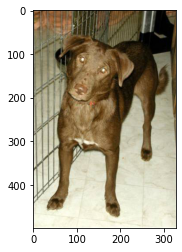

In [11]:
filename = 'dog.' + str(1) + '.jpg'
image = imread(train_folder + filename)
plt.imshow(image)
plt.show()

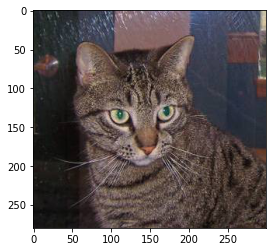

In [12]:
filename = 'cat.' + str(1) + '.jpg'
image = imread(train_folder + filename)
plt.imshow(image)
plt.show()

### Preprocessing

In [13]:
# create directories
subdirs = ['train/', 'val/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = train_folder + subdir + labldir
		os.makedirs(newdir, exist_ok=True)

In [14]:
# seed random number generator
seed(42)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in os.listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random.random() < val_ratio:
		dst_dir = 'val/'
	if file.startswith('cat'):
		dst = train_folder + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = train_folder + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

### Modeling

In [15]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [16]:
# prepare iterators
train = datagen.flow_from_directory('./train/train/', class_mode='binary', batch_size=64, target_size=(200, 200))
val = datagen.flow_from_directory('./train/val/', class_mode='binary', batch_size=64, target_size=(200, 200))

Found 18722 images belonging to 2 classes.
Found 6278 images belonging to 2 classes.


In [17]:
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(200, 200))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 200, 200, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

In [18]:
def load_image2(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

##### Model 1

In [19]:
# model build
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

In [20]:
# fit model
path = './drive/MyDrive/Colab Notebooks/MSDS422/'

# csv_logger = CSVLogger(path + 'training.log', separator=',', append=False)
# model.fit_generator(train, steps_per_epoch=len(train), validation_data=val, 
#                               validation_steps=len(val), epochs=20, verbose=0, callbacks=[csv_logger])

In [21]:
# Save model
# model.save(
#     path + 'cnn1.h5', 
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None,
#     save_traces=True,
# )

In [22]:
# load model
model = load_model(path + 'cnn1.h5')
log_data = pd.read_csv(path + 'training.log', sep=',', engine='python')

In [23]:
# evaluate model
_, acc = model.evaluate(val, steps=len(val), verbose=0)
print(acc)

0.8720930218696594


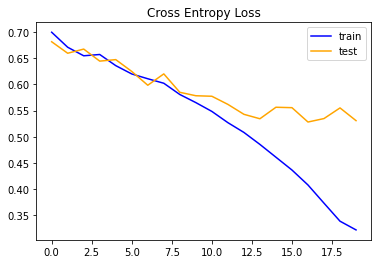

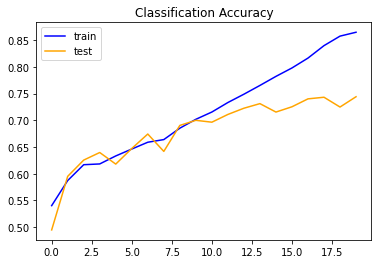

In [24]:
# plot loss
plt.title('Cross Entropy Loss')
plt.plot(log_data['loss'], color='blue', label='train')
plt.plot(log_data['val_loss'], color='orange', label='test')
plt.legend(['train', 'test'], loc='best')
plt.show()
# plot accuracy
plt.title('Classification Accuracy')
plt.plot(log_data['acc'], color='blue', label='train')
plt.plot(log_data['val_acc'], color='orange', label='test')
plt.legend(['train', 'test'], loc='best')
plt.show()

Predict

In [25]:
# preds = []
# for file in os.listdir(test_folder):
#   image = load_image(test_folder + file)
#   pred = model.predict(image)
#   preds.append(int(pred[0][0]))

In [26]:
# id = range(1, len(preds) + 1)
# submission= pd.DataFrame({"id": id, "label": preds})
# submission.to_csv("./drive/MyDrive/Colab Notebooks/MSDS422/dogcat_submission_1.csv", index = False)

What's weird is that loading in and evaluating the saved model yields a higher accuracy score even though a random seed was set. The training history was also saved and shows an accuracy score of ~70% after 20 epochs. I understand that training/validation score from the training history will slightly differ from the evaluation due to the batching of data during training vs. the evluation of the total dataset, but the accuracy score from .evluate was much lower than ~87%. 

In addition to this, it seems as though the prediction submissions to Kaggle yielded an odd result. The output of the predictions above are binary representing the Dog vs. Cat classes, although Kaggle may have been expecting the percentage that the prediction falls into each class instead.

##### Model 2

In [27]:
# model build
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(1, activation='sigmoid'))
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [28]:
# csv_logger2 = CSVLogger(path + 'training2.log', separator=',', append=False)
# model2.fit_generator(train, steps_per_epoch=len(train), validation_data=val, 
#                               validation_steps=len(val), epochs=20, verbose=0, callbacks=[csv_logger2])

In [29]:
# # Save model
# model2.save(
#     path + 'cnn2.h5', 
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None,
#     save_traces=True,
# )

In [30]:
# load model
model2 = load_model(path + 'cnn2.h5')
log_data2 = pd.read_csv(path + 'training2.log', sep=',', engine='python')

In [31]:
# evaluate model
_, acc2 = model2.evaluate(val, steps=len(val), verbose=0)
print(acc2)

0.9386747479438782


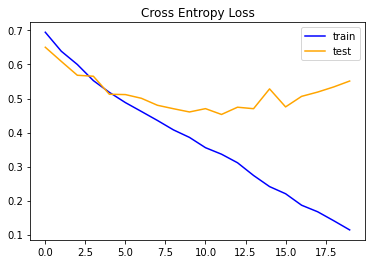

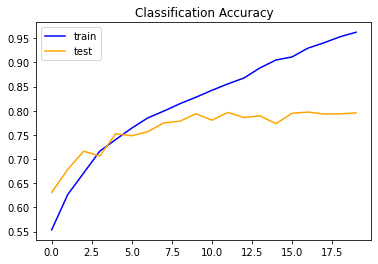

In [32]:
# plot loss
plt.title('Cross Entropy Loss')
plt.plot(log_data2['loss'], color='blue', label='train')
plt.plot(log_data2['val_loss'], color='orange', label='test')
plt.legend(['train', 'test'], loc='best')
plt.show()
# plot accuracy
plt.title('Classification Accuracy')
plt.plot(log_data2['acc'], color='blue', label='train')
plt.plot(log_data2['val_acc'], color='orange', label='test')
plt.legend(['train', 'test'], loc='best')
plt.show()

Predict

In [33]:
# preds2 = []
# id2 = []
# for file in os.listdir(test_folder):
#   image = load_image(test_folder + file)
#   pred2 = model2.predict(image)
#   preds2.append(int(pred2[0][0]))

In [34]:
# id = range(1, len(preds) + 1)
# submission2 = pd.DataFrame({"id": id, "label": preds2})
# submission2.to_csv("./drive/MyDrive/Colab Notebooks/MSDS422/dogcat_submission_2.csv", index = False)

Model 2 performed better, although not quite the ~94% accuracy shown above. The initial accuracy score for the evaluation was closer to 80%. Again loading in a saved model yielded different results even though a random seed was set. 

##### Model 3

In [35]:
# build model
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [36]:
# csv_logger3 = CSVLogger(path + 'training3.log', separator=',', append=False)
# model3.fit_generator(train, steps_per_epoch=len(train), validation_data=val, 
#                               validation_steps=len(val), epochs=70, verbose=0, callbacks=[csv_logger3])

In [37]:
# Save model
# model3.save(
#     path + 'cnn3.h5', 
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None,
#     save_traces=True,
# )

In [38]:
# load model
model3 = load_model(path + 'cnn3.h5')
log_data3 = pd.read_csv(path + 'training3.log', sep=',', engine='python')

In [39]:
# evaluate model
_, acc3 = model3.evaluate(val, steps=len(val), verbose=0)
print(acc3)

0.954603374004364


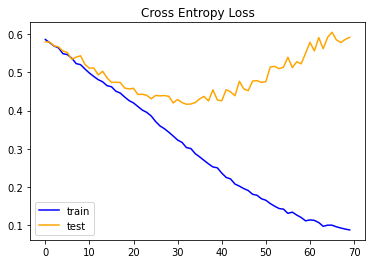

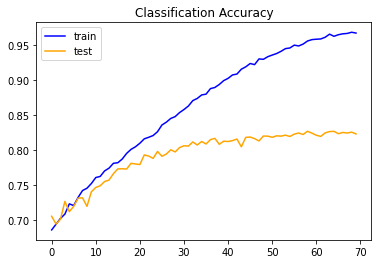

In [40]:
# plot loss
plt.title('Cross Entropy Loss')
plt.plot(log_data3['loss'], color='blue', label='train')
plt.plot(log_data3['val_loss'], color='orange', label='test')
plt.legend(['train', 'test'], loc='best')
plt.show()
# plot accuracy
plt.title('Classification Accuracy')
plt.plot(log_data3['acc'], color='blue', label='train')
plt.plot(log_data3['val_acc'], color='orange', label='test')
plt.legend(['train', 'test'], loc='best')
plt.show()

Predict

In [41]:
# preds3 = []
# for file in os.listdir(test_folder):
#   image = load_image(test_folder + file)
#   pred3 = model3.predict(image)
#   preds3.append(int(pred3[0][0]))

In [42]:
# id = range(1, len(preds3) + 1)
# submission3 = pd.DataFrame({"id": id, "label": preds3})
# submission3.to_csv("./drive/MyDrive/Colab Notebooks/MSDS422/dogcat_submission_3.csv", index = False)

#### Model 4

In [43]:
# build model
model4 = VGG16(include_top=False, input_shape=(224, 224, 3))
# mark loaded layers as not trainable
for layer in model4.layers:
  layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model4.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(1, activation='sigmoid')(class1)
# define new model
model4 = Model(inputs=model4.inputs, outputs=output)

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

58900480/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [44]:
datagen = ImageDataGenerator(featurewise_center=True)

# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]

# prepare iterator
train = datagen.flow_from_directory('./train/train/', class_mode='binary', batch_size=64, target_size=(224, 224))
val = datagen.flow_from_directory('./train/val/', class_mode='binary', batch_size=64, target_size=(224, 224))

Found 18722 images belonging to 2 classes.
Found 6278 images belonging to 2 classes.


In [45]:
# csv_logger4 = CSVLogger(path + 'training4.log', separator=',', append=False)
# model4.fit_generator(train, steps_per_epoch=len(train), validation_data=val,
#                      validation_steps=len(val), epochs=20, verbose=0, callbacks=[csv_logger4])

In [46]:
# # save model
# model4.save(
#     path + 'cnn4.h5', 
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None,
#     save_traces=True,
# )

In [47]:
# load model
model4 = load_model(path + 'cnn4.h5')
log_data4 = pd.read_csv(path + 'training4.log', sep=',', engine='python')

In [49]:
# evaluate model
_, acc4 = model4.evaluate(val, steps=len(val), verbose=0)
print(acc4)

0.9955399632453918


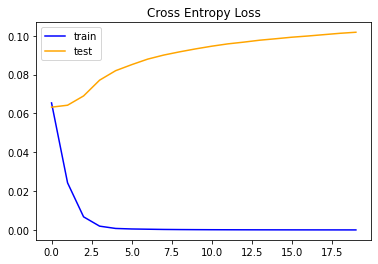

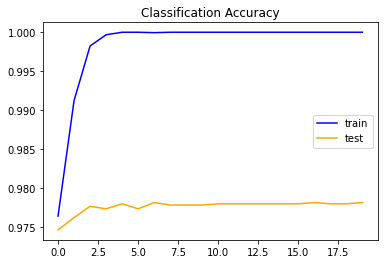

In [50]:
# plot loss
plt.title('Cross Entropy Loss')
plt.plot(log_data4['loss'], color='blue', label='train')
plt.plot(log_data4['val_loss'], color='orange', label='test')
plt.legend(['train', 'test'], loc='best')
plt.show()
# plot accuracy
plt.title('Classification Accuracy')
plt.plot(log_data4['acc'], color='blue', label='train')
plt.plot(log_data4['val_acc'], color='orange', label='test')
plt.legend(['train', 'test'], loc='best')
plt.show()

Predict

In [55]:
# preds4 = []
# for file in os.listdir(test_folder):
#   image = load_image2(test_folder + file)
#   # pred4 = model4.predict(image)
#   pred4 = model4.predict_proba(image)
#   preds4.append(int(pred4[0][0]))

In [56]:
# id = range(1, len(preds4) + 1)
# submission4 = pd.DataFrame({"id": id, "label": preds4})
# submission4.to_csv("./drive/MyDrive/Colab Notebooks/MSDS422/dogcat_submission_4.csv", index = False)

Model 4 performed the best at ~97% vs. the 99% shown above. I still have yet to figure out why the submission score from Kaggle looks weird, but looking at the images individually and what this model predicted shows that it performed quite well on unseen data.